# Data pre-processing

In [1]:
import cv2
import os
import numpy as np 
from keras.utils import np_utils
from zipfile import ZipFile


extract images to working directory

In [2]:
# file_name = "./fmr_dataset2.zip"
# with ZipFile(file_name, 'r') as zipf:
#     zipf.extractall() 


parse folder names (with/without mask) to categories and map to binary labels

In [3]:
data_path='./fmr_dataset2'
classes=os.listdir(data_path)
labels=[l for l, c in enumerate(classes)]
classes_labels = dict(zip(classes, labels))
print(classes_labels)

{'without_mask': 0, 'with_mask': 1}


load the images to greyscale and resize them

In [4]:
IM_SIZE = 33
data = []
labels = []

for c in classes:
    class_folder_path=os.path.join(data_path, c)
    im_names=os.listdir(class_folder_path)
        
    for n in im_names:
        im_path = os.path.join(class_folder_path,n)
        im_gray = cv2.imread(im_path, 0)
        im_resized = cv2.resize(im_gray,(IM_SIZE,IM_SIZE))
        data.append(im_resized)
        labels.append(classes_labels[c])

normalize the pixel arrays and convert labels to one-hot vectors, save those variables for use with keras

In [5]:
data = np.array(data)/255.
data = data.reshape((data.shape[0],IM_SIZE,IM_SIZE,1))
labels = np_utils.to_categorical(np.array(labels))

# Training 

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

create a cnn 

In [7]:
model=Sequential()
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 31, 31, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0

compile it

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

split the data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)

In [11]:
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
callback_list= [earlystopper, checkpoint]

In [12]:
training=model.fit(X_train, y_train, epochs=70, callbacks=callback_list, validation_split=0.2)

Epoch 1/70
86/87 [============================>.] - ETA: 0s - loss: 0.6335 - accuracy: 0.6225
Epoch 00001: val_loss improved from inf to 0.50965, saving model to model.h5
87/87 [==============================] - 11s 121ms/step - loss: 0.6332 - accuracy: 0.6227 - val_loss: 0.5097 - val_accuracy: 0.7304
Epoch 2/70
86/87 [============================>.] - ETA: 0s - loss: 0.4816 - accuracy: 0.7653
Epoch 00002: val_loss improved from 0.50965 to 0.39389, saving model to model.h5
87/87 [==============================] - 12s 143ms/step - loss: 0.4817 - accuracy: 0.7651 - val_loss: 0.3939 - val_accuracy: 0.8188
Epoch 3/70
86/87 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8143
Epoch 00003: val_loss did not improve from 0.39389
87/87 [==============================] - 14s 156ms/step - loss: 0.3987 - accuracy: 0.8144 - val_loss: 0.4346 - val_accuracy: 0.8188
Epoch 4/70
86/87 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.8423
Epoch 00004: val_lo

train the cnn

In [13]:
model = load_model('model.h5')


# Evaluation

In [14]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plot loss and accuracy on train and dev sets

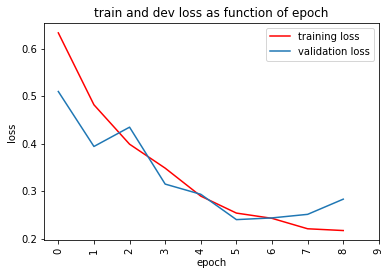

In [15]:
plt.plot(training.history['loss'],'r', label='training loss')
plt.plot(training.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(np.arange(10), rotation='vertical')
plt.title('train and dev loss as function of epoch')
plt.legend()
plt.show()

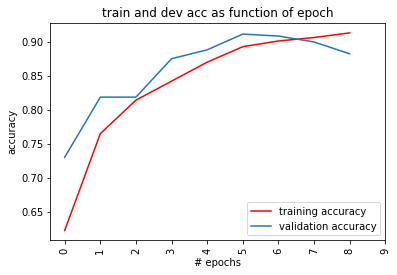

In [16]:
plt.plot(training.history['accuracy'],'r',label='training accuracy')
plt.plot(training.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.xticks(np.arange(10), rotation='vertical')
plt.ylabel('accuracy')
plt.title('train and dev acc as function of epoch')
plt.legend()
plt.show()

evaluate the model

In [17]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 29ms/step - loss: 0.2230 - accuracy: 0.9115


[0.22295920550823212, 0.9114583134651184]

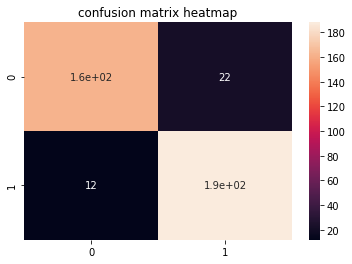

In [18]:
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)), annot=True)
plt.title('confusion matrix heatmap')
plt.show()

In [19]:
cr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cr)


              precision    recall  f1-score   support

           0       0.93      0.88      0.91       184
           1       0.90      0.94      0.92       200

    accuracy                           0.91       384
   macro avg       0.91      0.91      0.91       384
weighted avg       0.91      0.91      0.91       384



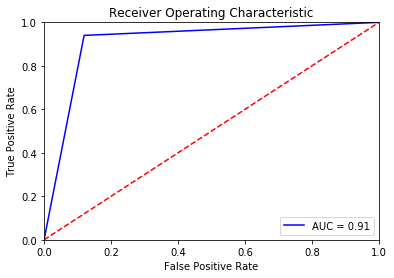

In [20]:
import sklearn.metrics as metrics
preds = y_pred.argmax(axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test.argmax(axis=1), preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [23]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
labels_dict={1:'with_mask',0:'without_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_img=gray[y:y+w,x:x+w]        
        resized=cv2.resize(face_img,(IM_SIZE,IM_SIZE))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,IM_SIZE,IM_SIZE,1))
        result=model.predict(reshaped)
        label=np.argmax(result,axis=1)[0]
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(frame,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(frame, labels_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
        
    cv2.imshow('LIVE',frame)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
cap.release()
